In [0]:
from fastai.text import *

In [0]:
bs=64

In [3]:
path = untar_data(URLs.HUMAN_NUMBERS)
path.ls()

[PosixPath('/root/.fastai/data/human_numbers/valid.txt'),
 PosixPath('/root/.fastai/data/human_numbers/train.txt')]

In [0]:
def readnums(d):
    return [', '.join(o.strip() for o in open(path/d).readlines())]

In [5]:
train_txt = readnums('train.txt')
train_txt[0][:80]

'one, two, three, four, five, six, seven, eight, nine, ten, eleven, twelve, thirt'

In [6]:
valid_txt = readnums('valid.txt')
valid_txt[0][-80:]

' nine thousand nine hundred ninety eight, nine thousand nine hundred ninety nine'

In [0]:
train = TextList(train_txt, path=path)
valid = TextList(valid_txt, path=path)

In [0]:
src = ItemLists(path=path, train=train, valid=valid).label_for_lm()
data = src.databunch(bs=bs)

In [9]:
train[0].text[:80]

'xxbos one , two , three , four , five , six , seven , eight , nine , ten , eleve'

In [10]:
len(data.valid_ds[0][0].data)

13017

In [11]:
data.bptt, len(data.valid_dl)

(70, 3)

In [0]:
it = iter(data.valid_dl)
x1,y1 = next(it)
x2,y2 = next(it)
x3,y3 = next(it)
it.close()

In [15]:
x1.numel()+x2.numel()+x3.numel()

13440

In [16]:
x1.shape,y1.shape

(torch.Size([64, 70]), torch.Size([64, 70]))

In [17]:
x2.shape,y2.shape

(torch.Size([64, 70]), torch.Size([64, 70]))

In [18]:
x1[:, 0]

tensor([ 2,  9, 11, 12, 13, 11, 10,  9, 10, 14, 19, 25, 19, 15, 16, 11, 19,  9,
        10,  9, 19, 25, 19, 11, 19, 11, 10,  9, 19, 20, 11, 26, 20, 23, 20, 20,
        24, 20, 11, 14, 11, 11,  9, 14,  9, 20, 10, 20, 35, 17, 11, 10,  9, 17,
         9, 20, 10, 20, 11, 20, 11, 20, 20, 20], device='cuda:0')

In [19]:
y1[:, 0]

tensor([19, 19, 27, 10,  9, 12, 32, 19, 26, 10, 11, 15, 11, 10,  9, 15, 11, 19,
        26, 19, 11, 18, 11, 18,  9, 18, 21, 19, 10, 10, 20,  9, 11, 16, 11, 11,
        13, 11, 13,  9, 13, 14, 20, 10, 20, 11, 24, 11,  9,  9, 16, 17, 20, 10,
        20, 11, 24, 11, 19,  9, 19, 11, 11, 10], device='cuda:0')

In [0]:
v = data.valid_ds.vocab

In [21]:
v.textify(x1[0])

'xxbos eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight'

In [22]:
v.textify(y1[0])

'eight thousand one , eight thousand two , eight thousand three , eight thousand four , eight thousand five , eight thousand six , eight thousand seven , eight thousand eight , eight thousand nine , eight thousand ten , eight thousand eleven , eight thousand twelve , eight thousand thirteen , eight thousand fourteen , eight thousand fifteen , eight thousand sixteen , eight thousand seventeen , eight thousand'

In [23]:
v.textify(x2[0])

'thousand eighteen , eight thousand nineteen , eight thousand twenty , eight thousand twenty one , eight thousand twenty two , eight thousand twenty three , eight thousand twenty four , eight thousand twenty five , eight thousand twenty six , eight thousand twenty seven , eight thousand twenty eight , eight thousand twenty nine , eight thousand thirty , eight thousand thirty one , eight thousand thirty two ,'

In [24]:
v.textify(x3[0])

'eight thousand thirty three , eight thousand thirty four , eight thousand thirty five , eight thousand thirty six , eight thousand thirty seven , eight thousand thirty eight , eight thousand thirty nine , eight thousand forty , eight thousand forty one , eight thousand forty two , eight thousand forty three , eight thousand forty four , eight thousand forty five , eight thousand forty six , eight'

In [25]:
v.textify(x1[1])

', eight thousand forty six , eight thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight , eight thousand fifty nine ,'

In [26]:
v.textify(x2[1])

'eight thousand sixty , eight thousand sixty one , eight thousand sixty two , eight thousand sixty three , eight thousand sixty four , eight thousand sixty five , eight thousand sixty six , eight thousand sixty seven , eight thousand sixty eight , eight thousand sixty nine , eight thousand seventy , eight thousand seventy one , eight thousand seventy two , eight thousand seventy three , eight thousand'

In [27]:
v.textify(x3[1])

'seventy four , eight thousand seventy five , eight thousand seventy six , eight thousand seventy seven , eight thousand seventy eight , eight thousand seventy nine , eight thousand eighty , eight thousand eighty one , eight thousand eighty two , eight thousand eighty three , eight thousand eighty four , eight thousand eighty five , eight thousand eighty six , eight thousand eighty seven , eight thousand eighty'

In [28]:
v.textify(x3[-1])

'ninety , nine thousand nine hundred ninety one , nine thousand nine hundred ninety two , nine thousand nine hundred ninety three , nine thousand nine hundred ninety four , nine thousand nine hundred ninety five , nine thousand nine hundred ninety six , nine thousand nine hundred ninety seven , nine thousand nine hundred ninety eight , nine thousand nine hundred ninety nine xxbos eight thousand one , eight'

In [30]:
data.show_batch(ds_type=DatasetType.Valid)

idx,text
0,"thousand forty seven , eight thousand forty eight , eight thousand forty nine , eight thousand fifty , eight thousand fifty one , eight thousand fifty two , eight thousand fifty three , eight thousand fifty four , eight thousand fifty five , eight thousand fifty six , eight thousand fifty seven , eight thousand fifty eight , eight thousand fifty nine , eight thousand sixty , eight thousand sixty"
1,"eight , eight thousand eighty nine , eight thousand ninety , eight thousand ninety one , eight thousand ninety two , eight thousand ninety three , eight thousand ninety four , eight thousand ninety five , eight thousand ninety six , eight thousand ninety seven , eight thousand ninety eight , eight thousand ninety nine , eight thousand one hundred , eight thousand one hundred one , eight thousand one"
2,"thousand one hundred twenty four , eight thousand one hundred twenty five , eight thousand one hundred twenty six , eight thousand one hundred twenty seven , eight thousand one hundred twenty eight , eight thousand one hundred twenty nine , eight thousand one hundred thirty , eight thousand one hundred thirty one , eight thousand one hundred thirty two , eight thousand one hundred thirty three , eight thousand"
3,"three , eight thousand one hundred fifty four , eight thousand one hundred fifty five , eight thousand one hundred fifty six , eight thousand one hundred fifty seven , eight thousand one hundred fifty eight , eight thousand one hundred fifty nine , eight thousand one hundred sixty , eight thousand one hundred sixty one , eight thousand one hundred sixty two , eight thousand one hundred sixty three"
4,"thousand one hundred eighty three , eight thousand one hundred eighty four , eight thousand one hundred eighty five , eight thousand one hundred eighty six , eight thousand one hundred eighty seven , eight thousand one hundred eighty eight , eight thousand one hundred eighty nine , eight thousand one hundred ninety , eight thousand one hundred ninety one , eight thousand one hundred ninety two , eight thousand"


## Single Fully Connected Model 

In [0]:
data = src.databunch(bs=bs, bptt=3)

In [33]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 3]), torch.Size([64, 3]))

In [36]:
nv = len(v.itos)
nv

39

In [0]:
nh = 64

In [0]:
def loss4(input, target):
    return F.cross_entropy(input, target[:,-1])

def acc4(input, target):
    return accuracy(input, target[:,-1])

In [0]:
class Model0(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.h_h = nn.Linear(nh, nh)
        self.h_o = nn.Linear(nh, nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
#         import pdb; pdb.set_trace()
        h = self.bn(F.relu(self.i_h(x[:,0])))
        if x.shape[1] > 1:
            h = h + self.i_h(x[:,1])
            h = self.bn(F.relu(self.h_h(h)))
        if x.shape[1] > 2:
            h = h + self.i_h(x[:,2])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [0]:
learn = Learner(data, Model0(), loss_func=loss4, metrics=acc4)

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


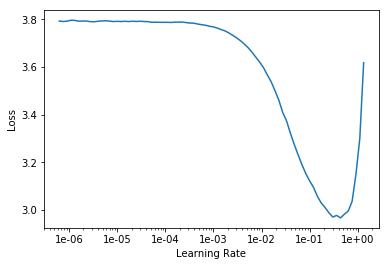

In [50]:
learn.recorder.plot()

In [58]:
learn.fit_one_cycle(10, 3e-2)

epoch,train_loss,valid_loss,acc4,time
0,1.425010,2.843905,0.319393,00:01
1,1.426651,2.943440,0.323759,00:01
2,1.424086,2.777973,0.316866,00:01
3,1.427136,3.147824,0.312270,00:01
4,1.425062,3.068620,0.318015,00:01
5,1.416048,2.723313,0.317785,00:01
6,1.416855,2.816701,0.317325,00:01
7,1.415423,2.833550,0.321461,00:01
8,1.409571,2.697852,0.321461,00:01
9,1.406007,2.756920,0.322610,00:01


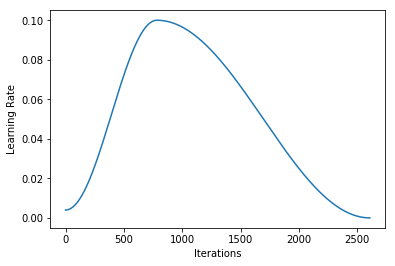

In [57]:
learn.recorder.plot_lr()

## Add a Loop Model

In [0]:
class Model1(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.h_h = nn.Linear(nh, nh)
        self.h_o = nn.Linear(nh, nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = self.bn(F.relu(self.h_h(h)))
        return self.h_o(h)

In [0]:
learn = Learner(data, Model1(), loss_func=loss4, metrics=acc4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


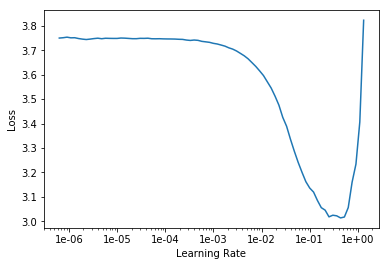

In [61]:
learn.lr_find()
learn.recorder.plot()

In [62]:
learn.fit_one_cycle(10, 1e-1)

epoch,train_loss,valid_loss,acc4,time
0,1.451014,2.288080,0.318244,00:01
1,1.441014,2.374980,0.323759,00:01
2,1.476975,2.288586,0.399357,00:01
3,1.469445,2.210504,0.398667,00:01
4,1.445428,2.339666,0.395680,00:01
5,1.423718,2.520274,0.321232,00:01
6,1.421828,2.790558,0.319623,00:01
7,1.442998,2.405021,0.318934,00:01
8,1.441182,2.564673,0.319393,00:01
9,1.439601,2.541347,0.321232,00:01


## Multi Fully Connecte model

In [0]:
data = src.databunch(bs=bs, bptt=20)

In [64]:
x, y = data.one_batch()
x.shape, y.shape

(torch.Size([64, 20]), torch.Size([64, 20]))

In [126]:
x[0]

tensor([ 9, 30,  9, 31,  9, 32,  9, 33,  9, 34,  9, 35,  9, 36,  9, 37,  9, 38,
         9, 21])

In [128]:
v.textify([38])

'nineteen'

In [0]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.h_h = nn.Linear(nh, nh)
        self.h_o = nn.Linear(nh, nv)
        self.bn = nn.BatchNorm1d(nh)
        
    def forward(self, x):
        h = torch.zeros(x.shape[0], nh).to(device=x.device)
        res = []
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = self.bn(F.relu(self.h_h(h)))
            res.append(self.h_o(h))
        return torch.stack(res, dim=1)

In [0]:
learn = Learner(data, Model2(), metrics=acc4)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


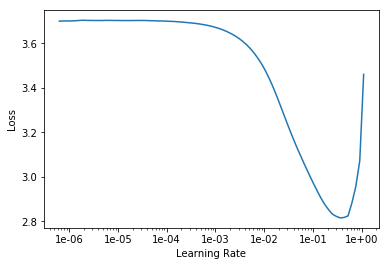

In [69]:
learn.lr_find()
learn.recorder.plot()

In [70]:
learn.fit_one_cycle(10, 1e-4, pct_start=0.1)

epoch,train_loss,valid_loss,acc4,time
0,3.678047,3.697803,0.024290,00:00
1,3.592198,3.596999,0.032031,00:00
2,3.484034,3.500690,0.054759,00:00
3,3.370190,3.417266,0.072372,00:00
4,3.262511,3.346653,0.079545,00:00
5,3.169439,3.293086,0.086364,00:00
6,3.096620,3.258198,0.088494,00:00
7,3.045628,3.239319,0.089631,00:00
8,3.014285,3.232093,0.089844,00:00
9,2.997927,3.231032,0.089702,00:00


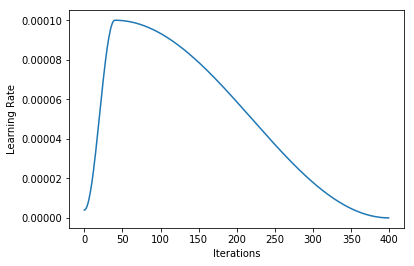

In [71]:
learn.recorder.plot_lr()

## Maintain State

In [0]:
class Model3(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.h_h = nn.Linear(nh, nh)
        self.h_o = nn.Linear(nh, nv)
        self.bn = nn.BatchNorm1d(nh)
        self.h = torch.zeros(bs, nh).cuda()
        
    def forward(self, x):
        h = self.h
        res = []
        for i in range(x.shape[1]):
            h = h + self.i_h(x[:,i])
            h = self.bn(F.relu(self.h_h(h)))
            res.append(h)
        self.h = h.detach()
        res = torch.stack(res, dim=1)
        res = self.h_o(res)
        return res

In [0]:
learn = Learner(data, Model3(), metrics=accuracy)

In [76]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.594188,3.462623,0.150213,00:00
1,3.231709,2.860784,0.410866,00:00
2,2.585574,2.106765,0.466761,00:00
3,2.013490,2.017298,0.317259,00:00
4,1.696734,2.021033,0.347159,00:00
5,1.486989,1.997149,0.427202,00:00
6,1.318933,2.027770,0.497301,00:00
7,1.170953,2.147504,0.518111,00:00
8,1.037596,2.218637,0.547585,00:00
9,0.926555,2.223999,0.577699,00:00


## Using RNN

In [0]:
class Model4(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.rnn = nn.RNN(nh, nh, batch_first=True)
        self.h_o = nn.Linear(nh, nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(1, bs, nh).cuda()
        
    def forward(self, x):
        res, h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        res = self.h_o(self.bn(res))
        return res

In [0]:
learn = Learner(data, Model4(), metrics=accuracy)

In [82]:
learn.fit_one_cycle(20, 3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.512121,3.359811,0.313352,00:00
1,3.052964,2.532541,0.454474,00:00
2,2.392473,1.908043,0.467401,00:00
3,1.902701,1.987698,0.315554,00:00
4,1.657837,2.042287,0.317401,00:00
5,1.503395,1.828701,0.436222,00:00
6,1.338123,1.642596,0.484233,00:00
7,1.145666,1.541708,0.513139,00:00
8,0.990203,1.556930,0.520952,00:00
9,0.865700,1.552543,0.549503,00:00


## 2-layer GRU

In [0]:
class Model5(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.rnn = nn.GRU(nh, nh, 2, batch_first=True)
        self.h_o = nn.Linear(nh, nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = torch.zeros(2, bs, nh).cuda()
        
    def forward(self, x):
        res, h = self.rnn(self.i_h(x), self.h)
        self.h = h.detach()
        res = self.h_o(self.bn(res))
        return res

In [0]:
learn = Learner(data, Model5(), metrics=accuracy)

In [87]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.920536,2.432267,0.446449,00:00
1,1.808566,1.438203,0.647514,00:00
2,0.937192,1.272494,0.802202,00:00
3,0.452453,1.030215,0.819886,00:00
4,0.225654,1.030597,0.822017,00:00
5,0.117678,1.070011,0.829119,00:00
6,0.064475,1.080053,0.827628,00:00
7,0.037521,1.157755,0.826065,00:00
8,0.023447,1.202409,0.821591,00:00
9,0.016328,1.192192,0.821946,00:00


## Trying LSTM

In [0]:
class Model6(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.rnn = nn.LSTM(nh, nh, 2, batch_first=True)
        self.h_o = nn.Linear(nh, nv)
        self.bn = BatchNorm1dFlat(nh)
        self.h = (torch.zeros(2, bs, nh).cuda(), torch.zeros(2, bs, nh).cuda())
        
    def forward(self, x):
        res, h = self.rnn(self.i_h(x), self.h)
        self.h = (h[0].detach(), h[1].detach())
        res = self.h_o(self.bn(res))
        return res

In [0]:
learn = Learner(data, Model6(), metrics=accuracy)

In [107]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.914625,3.006705,0.458807,00:00
1,1.803397,1.463675,0.570810,00:00
2,0.927867,1.053521,0.783878,00:00
3,0.443565,0.894082,0.836932,00:00
4,0.219044,0.795127,0.837074,00:00
5,0.113204,0.736569,0.833594,00:00
6,0.060844,0.767543,0.832529,00:00
7,0.034696,0.793205,0.831534,00:00
8,0.021328,0.826688,0.831889,00:00
9,0.014604,0.836894,0.827202,00:00


## Trying Bidirectional

In [0]:
class Model7(nn.Module):
    def __init__(self):
        super().__init__()
        self.i_h = nn.Embedding(nv, nh)
        self.rnn = nn.LSTM(nh, nh, 2, bidirectional=True, batch_first=True)
        self.h_o = nn.Linear(nh*2, nv)
        self.bn = BatchNorm1dFlat(nh*2)
        self.h = (torch.zeros(4, bs, nh).cuda(), torch.zeros(4, bs, nh).cuda())
        
    def forward(self, x):
        res, h = self.rnn(self.i_h(x), self.h)
        self.h = (h[0].detach(), h[1].detach())
        res = self.h_o(self.bn(res))
        return res

In [0]:
learn = Learner(data, Model7(), metrics=accuracy)

In [123]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.209705,2.225651,0.769673,00:00
1,0.882324,0.442984,0.880043,00:00
2,0.427093,0.360786,0.904972,00:00
3,0.227121,0.267653,0.936222,00:00
4,0.131258,0.322445,0.905043,00:00
5,0.078736,0.399587,0.886506,00:00
6,0.047332,0.416769,0.882599,00:00
7,0.027909,0.456152,0.883736,00:00
8,0.016098,0.448914,0.889063,00:00
9,0.009958,0.456476,0.889205,00:00


In [0]:
def get_next(inp):
    idxs = Text.nu